In [2]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../../utils/")
sys.path.append("../")
from torch.utils.data import DataLoader
from utils import MyDataset, Normalize
from tqdm import tqdm
from networks.allaire_net import Allaire_Net
from networks.conv_net import Conv_Net
from networks.conv_net_2 import Conv_Net2
from networks.unet import U_Net
from networks.utils import EarlyStopper
import json
import argparse
import os

In [3]:
transform = Normalize(root="../../data")
dataset = MyDataset(root="../../data", tform=transform)
train_dataset, validation_dataset, test_dataset =torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = torch.utils.data.DataLoader(train_dataset)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8)

In [14]:
map = plt.imread("./attention_maps/ewes/500.png")

In [15]:
filtered = np.where(map > 0.7, map, 0.)

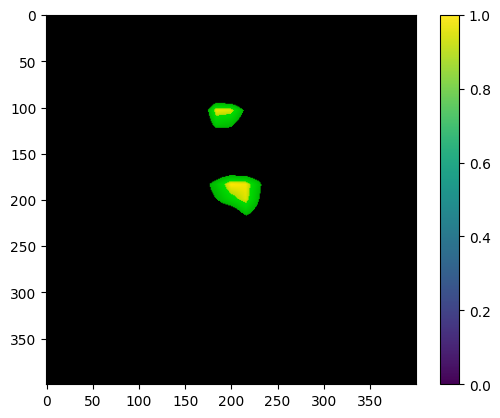

In [16]:
plt.imshow(filtered)
plt.colorbar()